In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import matplotlib.ticker as ticker
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
#import openpyxl
#from openpyxl.workbook import Workbook

In [34]:
### PREP DATA ###

## MANUAL INPUT ## -- locate file
sensor = 'terraspec' #'PRISMA', 'WV3', 'Landsat8', 'terraspec'
target_file = 'C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/' + sensor + '_sc_spots.xlsx'
sensor_meta = pd.read_csv('C:/Users/htccr/Documents/Aconquija/python_scripts/keep/'+ sensor + '_meta.csv', header = 0, index_col = None)
 
data = pd.read_excel(target_file, sheet_name = 'continuum_removed', header = None, index_col = None) # choose sheet: 'band_mean', 'continuum', 'continuum_removed'
data_std = pd.read_excel(target_file, sheet_name = 'band_std', header = None, index_col = None)
data_vars = pd.read_excel(target_file, sheet_name = 'variables', header = 0, index_col = None)
spots_meta = pd.read_excel('C:/Users/htccr/Documents/Aconquija/python_scripts/outputs/spots_meta.xlsx',sheet_name = 'Sheet1', header = 0, index_col = None)

# decompact data_vars
age = np.array(data_vars['age'])
age_sd = np.array(data_vars['age_sd'])
age_n = np.array(data_vars['age_n'])
fan = np.array(data_vars['fan'])
unit = np.array(data_vars['unit'])
unique = np.array(data_vars['unique'])
pix_count = np.array(data_vars['pix_count'])

# decompact sensor metadata (e.g. nm, band names) and create dictionaries
band_names = sensor_meta.Band
nm_names = sensor_meta.nm.values
nm_names = np.round(nm_names,1)
band_dict_nm = pd.Series(sensor_meta.Name.values,index=nm_names).to_dict()
band_dict_idx  = pd.Series(sensor_meta.Name.values,index=sensor_meta.index.values).to_dict() # create dictionary of band names to wavelength
nm_dict = pd.Series(sensor_meta.nm.values,index=sensor_meta.Band).to_dict() # create dictionary of band names to wavelength

if 'bad_age_idx' in locals():
    del bad_age_idx
if 'bad_band_idx' in locals():
    del bad_band_idx

## MANUAL INPUT ## -- set bands and/or ages to drop
#bad_band_idx = np.r_[230:234] # choose bands to drop by index
bad_age_idx = np.where((pix_count == 0) | (age == 3.37) | (age == 16.48) | (age == 78.5) | (age == 314.48))# | (unit == 'Q2.5a') | (unit == 'Q2.5b')) #  choose age to drop (two decimels)
if 'bad_age_idx' in locals():
    data = data.drop(np.r_[bad_age_idx], axis=0)
    data_std = data_std.drop(np.r_[bad_age_idx], axis=0)
    age = np.delete(age, bad_age_idx)
    age_sd = np.delete(age_sd, bad_age_idx)
    age_n = np.delete(age_n, bad_age_idx)
    fan = np.delete(fan, bad_age_idx)
    unit = np.delete(unit, bad_age_idx)
    unique = np.delete(unique, bad_age_idx)
    pix_count = np.delete(pix_count, bad_age_idx)
    spots_meta = spots_meta.drop(np.r_[bad_age_idx], axis=0)
    
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('some ages dropped')
else:
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No ages dropped')
    
# drop chosen values from dataset(s)
if 'bad_band_idx' in locals():
    data = data.drop(np.r_[bad_band_idx], axis=1)
    nm_names = np.delete(nm_names, bad_band_idx)
    data.iloc[:,bad_band_idx] = 0 # if bad bands chosen, set band bands as 0 for PCA`
    data_std.iloc[:,bad_band_idx] = 0
    
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    #data_plot.iloc[:,bad_band_idx] = np.nan
    #data_std_plot.iloc[:,bad_band_idx] = np.nan
    print('some bands dropped')
else:
    # data for plotting (nan instead of 0 for bad bands)
    data_plot = data.copy()
    data_std_plot = data_std.copy()
    print('No bands dropped')

print(np.shape(data))

some ages dropped
No bands dropped
(10, 2151)


#### Normalize data (optional), PCA function will appl normilization??

In [33]:
age

array([  0.  ,   5.11,   5.4 ,  16.45,  17.67,  26.3 ,  31.74, 107.7 ,
       212.15, 319.22])

In [24]:
# carry std through-- create relative matrix of std to refelctance value (i.e. decimel percentage), normlaize data, re-calc std using matrix

data_std = data_std/data.mean()
#data_std.iloc[:,bad_band_idx] = 0

# normalize each observation to have the same mean & std
data = (data - data.mean())/data.std()
#data.iloc[:,bad_band_idx] = 0

In [ ]:
log(0)
# log(1/R)
data = np.log(1/data)

In [ ]:
# 1st derivative
data = np.diff(data)/np.diff(nm_names)
data = pd.DataFrame(test)

nm_names = nm_names[1:]

In [ ]:
# normalize each observation to have the same mean & std
data = (data.T - data.T.mean())/data.T.std()
data = data.T

In [ ]:
# scale all observation to 0-1 range, using the same min and max
max_all = data.max().max()
min_all = data.min().max()

#norm01 = (norm01 - norm01.min())/(norm01.max() - norm01.min())
data = (data - min_all)/(max_all - min_all)

In [190]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
data = (data.T -  data.T.iloc[2208-350]) # choose band as zero point
max_all = data.max().max()
min_all = data.min().min()
data = (data - min_all)/(max_all - min_all) 
data = data.T

In [ ]:
# normlaize by BCET, on the final dataset (???)
# followed by normalization to a particular band
count = len(data.T)
BCET = pd.DataFrame()

for band_n in range(count):

    # Read band
    dat = data.iloc[:,band_n].astype(np.float64)

    # Shift the left minimum value to the current minimum, so the smallest value is now shifted to zero
    dat_masked_new = dat-np.min(dat)
    
    # Normalize between 0 and 1
    dat_masked_new *= 1/dat_masked_new.max()
    
    L = 0 # desired output minimum
    H = 1  # desired output maximum, set to max bit-depth range
    E = H/2 # desired output mean

    ### BCET ###

    s = np.nanmean(np.power(dat_masked_new,2)) # mean squared
    e = np.nanmean(dat_masked_new)
    l = np.nanmin(dat_masked_new)
    h = np.nanmax(dat_masked_new)

    # Find b
    b_nom = ((h**2)*(E-L))-(s*(H-L))+((l**2)*(H-E))
    b_den = 2*((h*(E-L))-(e*(H-L))+(l*(H-E)))

    b = b_nom/b_den

    # Find a
    a1 = H-L
    a2 = h-l
    a3 = h+l-(2*b)

    a = a1/(a2*a3)

    # Find c
    c = L-(a*(l-b)**2)
    
        # BCET malfunction test as in Lui & Mason (2016) Section 2.6.1. Where l<b<h BCET malfunctions. 
    if (l < b) & (b < h):
        print('\033[91m'+ 'BCET Fail' + '\033[0;0m' + ' (Band {})'.format(band_n + 1)) # print in red
        print("l, b, h --> ", l,", ", b,", ",h)
    else:
        pass #print('\033[92m' + 'BCET Pass' + '\033[0;0m' + ' (Band {})'.format(band_n + 1)) # print in green

    #print("l, b, h --> ", l,", ", b,", ",h)
    #print('------------------------------')
    #print(bcet_raster.shape)

    # Process raster
    bcet_raster = a*((dat_masked_new - b)**2) + c
    #BCET[band_n] = bcet_raster # replcaced w/ below
    hold = pd.Series(bcet_raster, name = band_n)
    to_concat = [BCET, hold]
    BCET = pd.concat(to_concat, axis = 1)

print('dynamic range ', L, 'to', H) # prints the desired dynamic range of the output image
print('target mean ', E) # prints the desired mean of the output image, 'E'
print('actual mean', np.mean(BCET.mean()))
print("processing complete.")
 
data = BCET

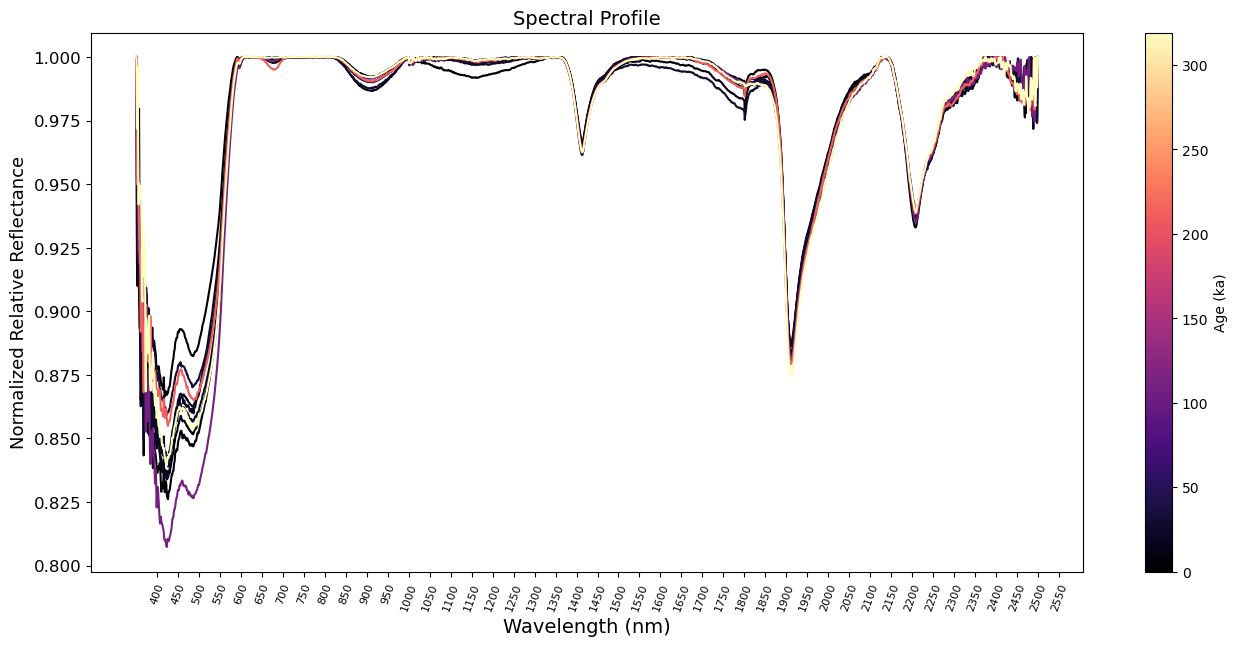

In [35]:
#plot
norm = plt.Normalize(vmin=min(age), vmax=max(age))

target_x = nm_names
target_y = data
target_names = age

N = len(target_y) # number of objects to plot i.e. color cycle count

fig, ax = plt.subplots(figsize = (16,7))
#for i in range(N):
    #ax.plot(target_x, target_y.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y
for i in range(N): 
    ax.plot(target_x, target_y.iloc[i],label = target_names[i], color=plt.cm.magma(norm(age[i])))
#axes
#plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.xticks(np.arange(400, 2600, 50), fontsize = 10, rotation=70, size = 8)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Wavelength (nm)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Normalized Relative Reflectance', fontsize = 13)
plt.title("Spectral Profile", size = 14)
plt.title
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

# legend location (if using discrete line key)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0 + box.height * 0.1,
                # box.width, box.height * .9])

#ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          #fancybox=True, shadow=True, ncol=1, title = 'Age (ky)') # Put a legend below current axis

plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()

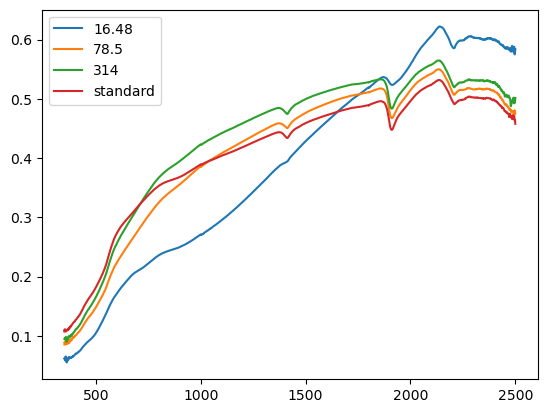

In [17]:
#plt.plot(nm_names, data.loc[0], label = '0')
#plt.plot(nm_names, data.loc[12], label = '12')
plt.plot(nm_names, data.loc[4], label = '16.48')
plt.plot(nm_names, data.loc[8], label = '78.5')
plt.plot(nm_names, data.loc[11], label = '314')
plt.plot(nm_names, data.loc[7], label = 'standard')
plt.legend()

In [157]:
data = data.T[1750:1950]


In [159]:
data = data.T

In [36]:
n_modes = np.min(np.shape(data)) 
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

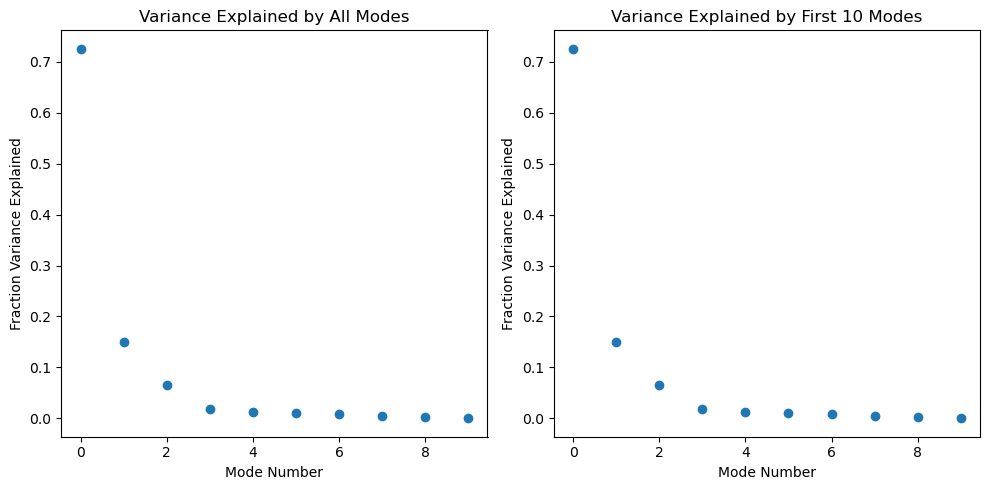

0.875519052291572

In [31]:
# plot fraction of variance explained by each mode
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

var_exp = fracVar[0] + fracVar[1]# + fracVar[2] + fracVar[3]
var_exp

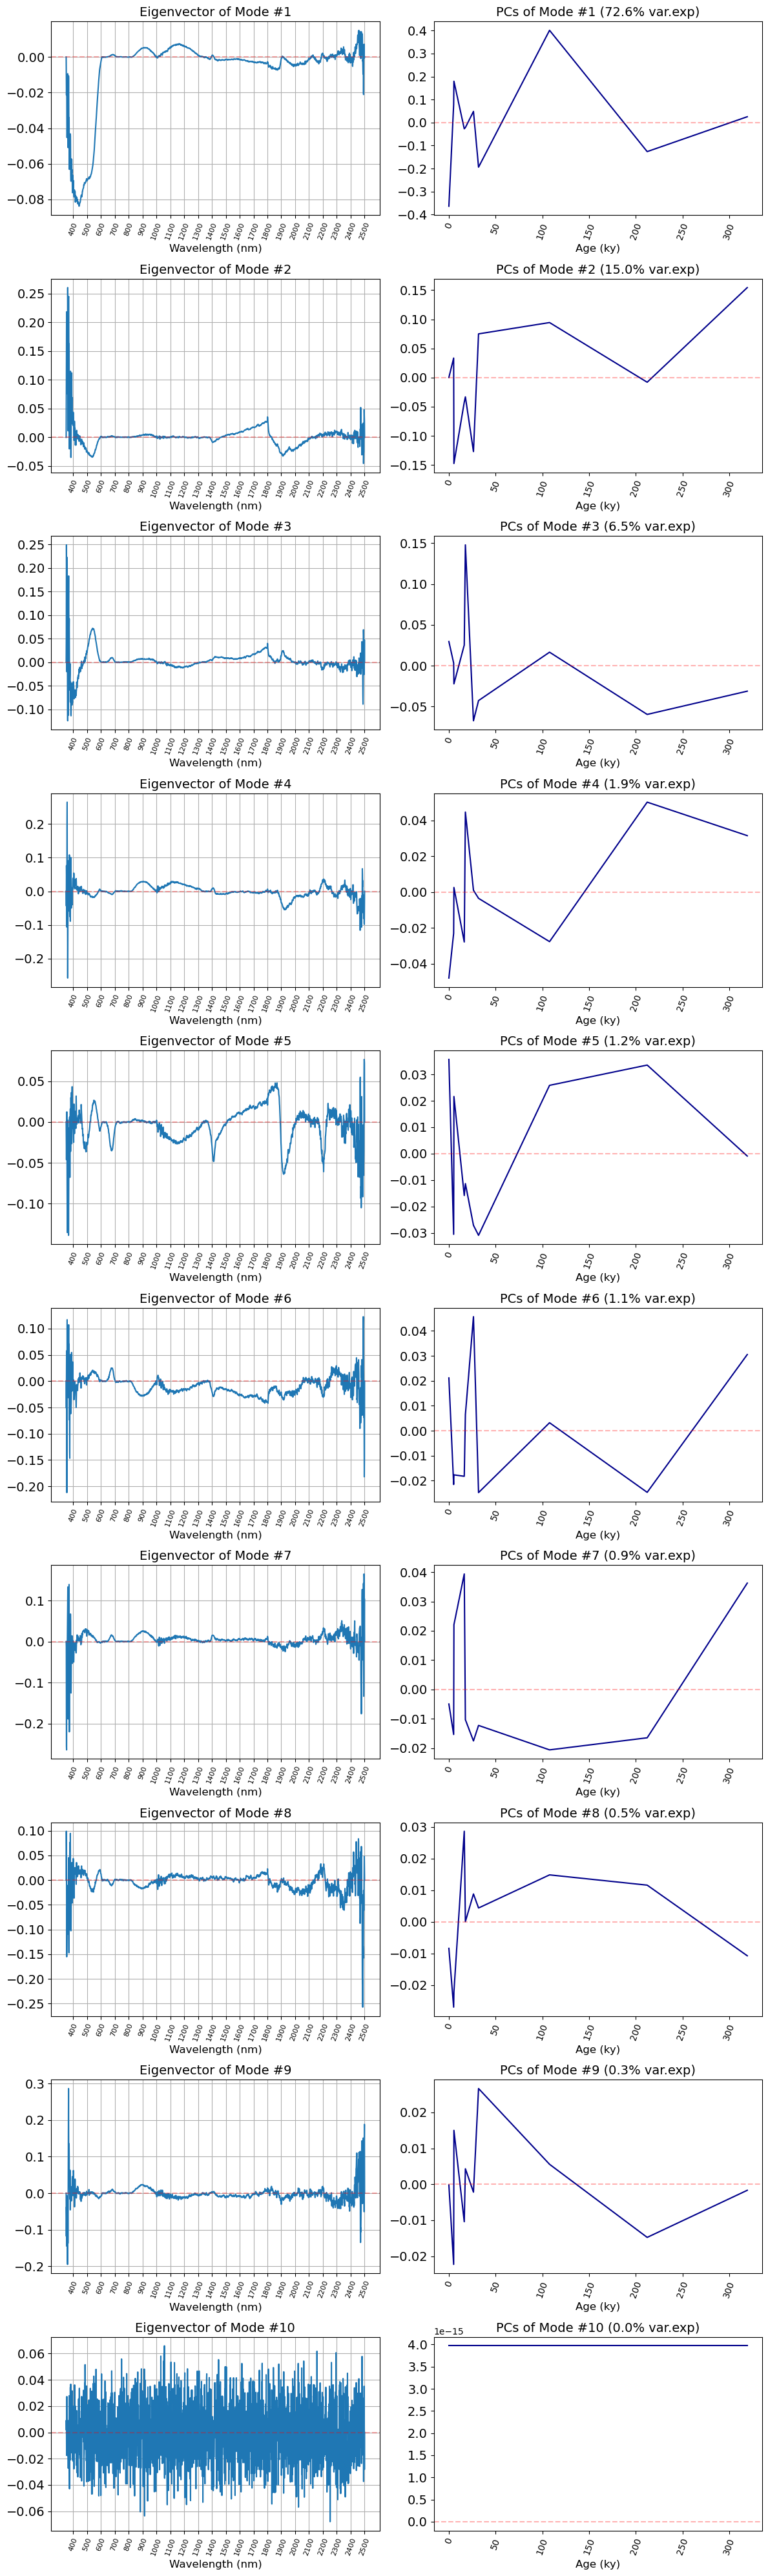

In [37]:
#plot the first n modes and PCs
n = 10

plt.figure(figsize=(12,4*n))
for kk in range(n):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names,eigvecs[kk,:]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    #plt.errorbar(age,PCs[:,kk], xerr=age_sd, fmt='o', c = 'darkblue', alpha = 0.8, zorder = 0)
    plt.plot(age,PCs[:,kk], c = 'darkblue', zorder = 1)
    #plt.colorbar(label = 'Age (ky)')
    plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)

    highlight_age_idx = np.r_[np.where((age == 3.37) | (age == 16.48) | (age == 78.5) | (age == 314.48))]
    highlight_age_ages = age[highlight_age_idx]
    PCs_highlight_ages = PCs[:,kk][highlight_age_idx]
    plt.scatter(highlight_age_ages, PCs_highlight_ages, c = 'r')
    
    highlight_ra_idx = np.r_[np.where((unit == 'Q2.5a') | (unit == 'Q2.5b'))]
    highlight_ra_ages = age[highlight_ra_idx]
    PCs_highlight_ra = PCs[:,kk][highlight_ra_idx]
    plt.scatter(highlight_ra_ages, PCs_highlight_ra, c = 'green')
plt.show()

# yonger fan variation may be due to water on the fans, which effects the signal. Drier fans
# color by location
# invesitgate the PC1, for its age. 


In [ ]:
np.shape(age)

In [ ]:
PC_n = 
diff_eig = coef_MLR
#diff_eig = data.T[0] - data.T[26]
#diff_eig = (diff_eig - diff_eig.min())/(diff_eig.max()-diff_eig.min())

PCA_eig = eigvecs[PC_n]
PCA_eig = (PCA_eig - PCA_eig.min())/(PCA_eig.max()-PCA_eig.min())

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(nm_names, diff_eig, c = 'red', label = 'eeigvec diff')
plt.plot(nm_names, PCA_eig, color = 'blue', label = 'PCA eigvec')
plt.legend()
plt.title('What is the eigvec?')

plt.subplot(122)
diff_PC = data*diff_eig 
diff_PC = np.sum(diff_PC, axis = 1)
diff_PC = (diff_PC - diff_PC.min())/(diff_PC.max() - diff_PC.min())

PCA_PC = PCs[:,PC_n]*-1
PCA_PC = (PCA_PC - PCA_PC.min())/(PCA_PC.max()- PCA_PC.min())

plt.scatter(age, diff_PC, c = 'r', label = 'PC_diff')
plt.scatter(age, PCA_PC, c = 'b', label = 'PCA PC')
plt.legend()

In [ ]:
plt.scatter(PCs[:,0],PCs[:,1], c = age)
plt.colorbar()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook
y = age

Xax = PCs[:,1]
Yax = PCs[:,2]
Zax = PCs[:,3]

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for i in range(N):
 ax.scatter(Xax[i], Yax[i], Zax[i], s=40,  color=plt.cm.magma(norm(age[i])))
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

#ax.legend()
plt.show()

In [ ]:
plt.scatter(age,PCs[:,0], c = spots_meta['MeanElevat'])
plt.colorbar()

In [183]:
## TARGET PC ##
target_PC = 1
target_PC = (PCs[:,target_PC])*-1



PC0 = PCs[:,0]
PC1 = PCs[:,1]
PC2 = PCs[:,2]
PC3 = PCs[:,3]
PC4 = PCs[:,4]

#target_PC =(PC0 + PC1) /2

(-15.961000000000002, 335.18100000000004)

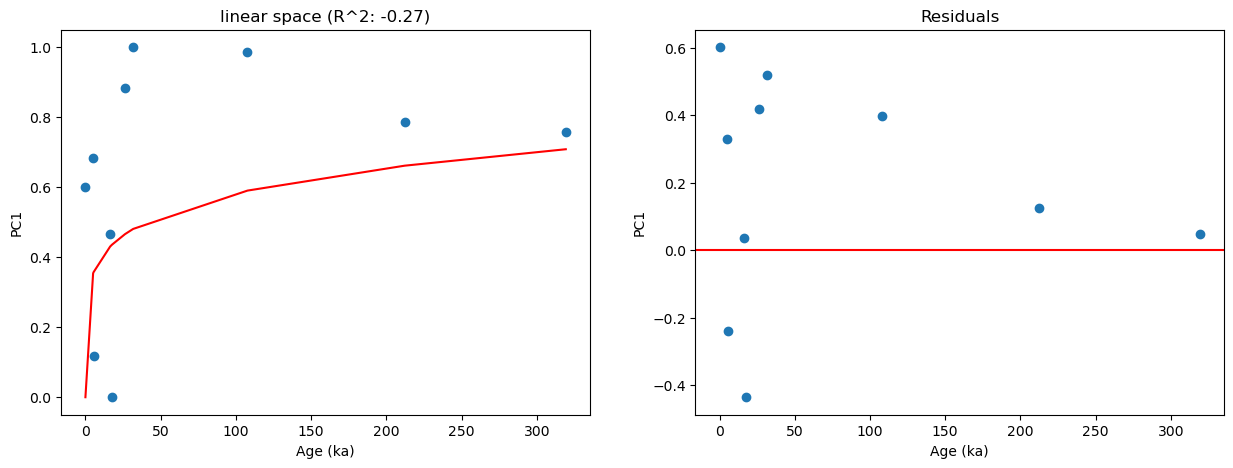

In [165]:
# define steady weathering rate of granites (White and Brandtly, 2001)
def weathering_rate(time):
    a = 3.31e-13 # white 2001
    b = 0.61 # white 2001
    a = 0.2691 # nui et al. 2019
    b = 0.1679 # nui et al. 2018
    #a = 0.59 # constant D'arcy
    #b = 0.16 # exponent D'arcy
    rate = a*(time**b)
    return(rate)

PC1_posative = (target_PC-min(target_PC))/(max(target_PC)-min(target_PC))

wr = weathering_rate(age)
#PC1_posative = target_PC  - target_PC.min()
residuals = PC1_posative - wr

# correlation coefficient (r^2)
r2 = r2_score(PC1_posative, wr)
r2 = round(r2,2)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(age, PC1_posative)
plt.plot(age, wr, color='red')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('linear space (R^2: {})'.format(r2))
#plt.xscale('log')
#plt.yscale('log')


plt.subplot(1,2,2)
plt.scatter(age, residuals)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('Residuals'.format(r2))

plt.xlim()

linear: y=0.0x+[[0.16]]
Power funtion: y = 1.0x^[[0.16]]


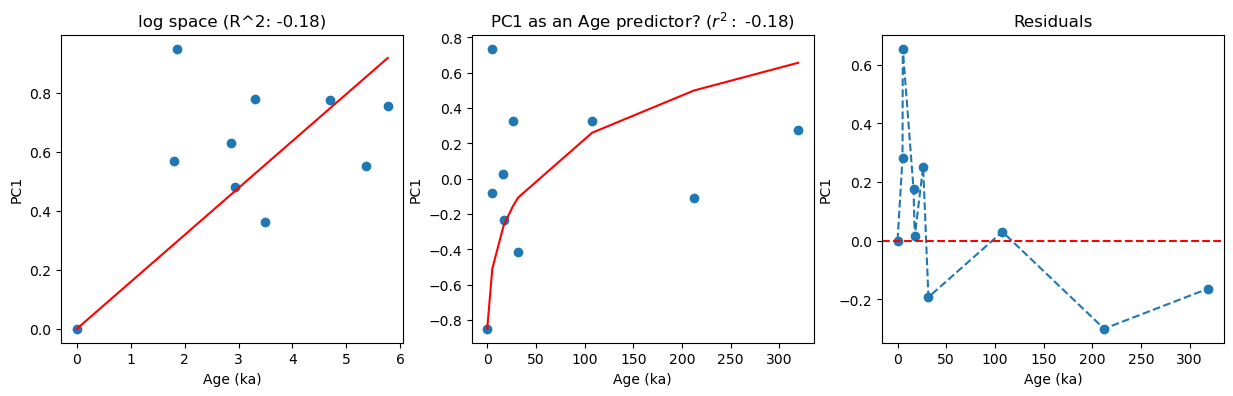

In [184]:
# Fit Power law function and take resiudals (without 0)
# take ln of x and y, run linear regression, plot and unpack
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# data
PC1 = np.array(target_PC)
PC1_posative = (PC1 - PC1.min()) + 1 # scale PC1 to remove negatives, and add 1 to compute log(0) as 0

age_log = age + 1   # add 1 to compute log(0) as 0

# take natural log
age_log = np.log(age_log) 
PC1_log = np.log(PC1_posative)

# run linear regression
X = age_log.reshape(-1,1) # values converts it into a numpy array
Y = PC1_log.reshape(-1,1) # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make Y predictions from regression line

# calculate residuals
residuals = Y - Y_pred
residuals = residuals.reshape(1,-1)
residuals = residuals[0]

# unpack from log-log into linear space, as origionally scaled 
Y_pred_unpacked = (np.exp(Y_pred))
Y_pred_unpacked = Y_pred_unpacked - 1
Y_pred_unpacked = Y_pred_unpacked + PC1.min()

Y_unpacked = (np.exp(Y))
Y_unpacked = Y_unpacked - 1
Y_unpacked = Y_unpacked + PC1.min()

X_unpacked = (np.exp(X)) - 1

# correlation coefficient (r^2)
r2 = r2_score(Y, Y_pred)
r2 = round(r2,2)

#rho, p = spearmanr(Y, Y_pred)
#spearmans_r2 = rho**2

# plot results
plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('log space (R^2: {})'.format(r2))

plt.subplot(1,3,2)
plt.scatter(X_unpacked, Y_unpacked)
plt.plot(X_unpacked, Y_pred_unpacked, color='red')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('PC1 as an Age predictor? ($r^2:$ {})'.format(r2))


plt.subplot(1,3,3)
plt.scatter(X_unpacked, residuals)
plt.plot(X_unpacked, residuals, linestyle = '--')
plt.axhline(y=0.0, color='r', linestyle='--')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('Residuals'.format(r2))

# Equations
B = np.round(linear_regressor.coef_,2)
A = np.round(linear_regressor.intercept_,2)
A_pl = np.round(np.exp(A),2)
print('linear: y={}x+{}'.format(A,B))

print('Power funtion: y = {}x^{}'.format(A_pl,B))

Text(0.5, 1.0, 'Residuals')

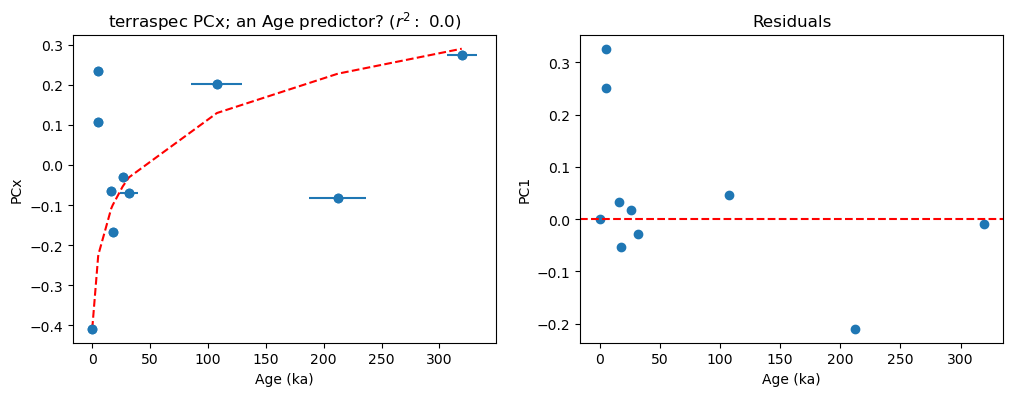

In [111]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(X_unpacked, Y_unpacked)
plt.plot(X_unpacked, Y_pred_unpacked, color='red', linestyle = '--')
plt.errorbar(X_unpacked, Y_unpacked, xerr=age_sd, fmt='o')
plt.xlabel('Age (ka)')
plt.ylabel('PCx')
plt.title(sensor + ' PCx; an Age predictor? ($r^2:$ {})'.format(r2))

plt.subplot(1,2,2)
plt.scatter(X_unpacked, residuals)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.xlabel('Age (ka)')
plt.ylabel('PC1')
plt.title('Residuals'.format(r2))


In [185]:
# long term dO18 record
# import data
from numpy import linspace, loadtxt, ones, convolve

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# prep data
O18_global = pd.read_csv('O18_global_karner2002.csv', header = 0)
O18_global = O18_global.rename(columns={O18_global.columns[0]: "age", O18_global.columns[1]: 'dO18'})
O18_global = O18_global.replace({999:np.NaN})

#O18_global = O18_global.reset_index(drop = True) # reset row index
#O18_global['dO18'] = O18_global['dO18'] * -1 # inverse the data 

age_fans = age[age > 0] # fans with age > 0 

ice_proxy = O18_global.loc[O18_global['age'] >= age_fans.min()] # paleo data with age > 0 
ice_proxy = ice_proxy.loc[ice_proxy['age'] <= max(age_fans)] # paleo data with age < max age chosen
age_proxy = ice_proxy['age']

#fans = residuals[1:]
fans = target_PC[1:]
#y_rec_ratio = (data[193]/data[157])*-1
#fans = y_rec_ratio[1:]
# normalize each dataset
ice_proxy['dO18'] = (ice_proxy['dO18'] - ice_proxy['dO18'].mean())/ice_proxy['dO18'].std()
fans = (fans - fans.mean())/fans.std()


Text(0.5, 1.0, 'Global Paleoclimate: Global Temperature ($r^2 = $ 0.18)')

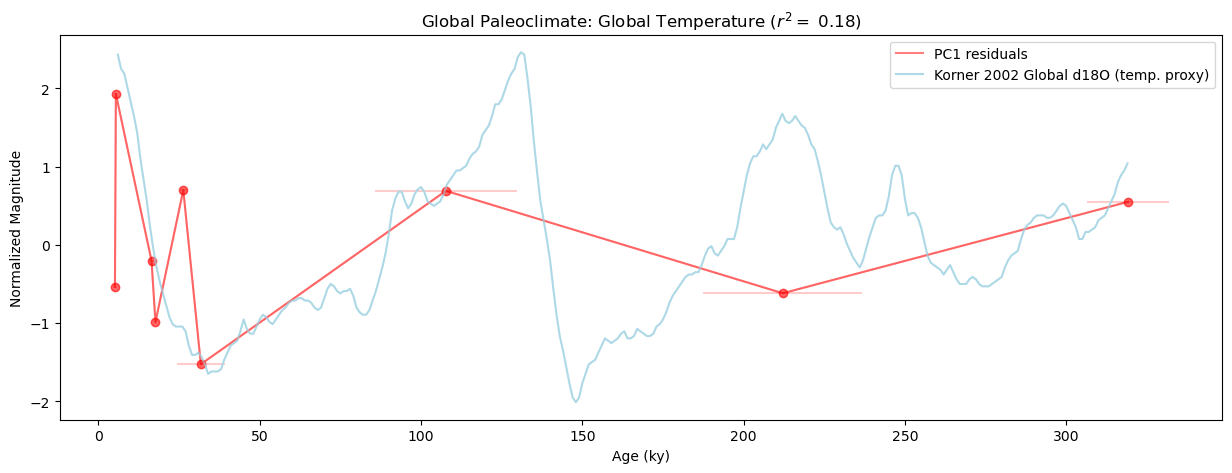

In [186]:
# Plot
fans_avg = movingaverage(fans, 1)
fan_pts = np.interp(age_proxy, age_fans, fans)
window = 1
ice_proxy_avg = movingaverage(ice_proxy['dO18'], window)
yrs_per_window = (ice_proxy['dO18'].max() - ice_proxy['dO18'].min())/len(ice_proxy['dO18'])
yrs_per_window = round(yrs_per_window * window, 1)

plt.figure(figsize = (15,5))
plt.scatter(age_fans, fans, color = 'red', alpha = 0.5) # residual data 
plt.plot(age_fans, fans_avg, color = 'red', alpha = 0.5, label = 'PC1 residuals')
#plt.plot(age_proxy, ice_proxy_avg, color = 'lightblue', alpha = 1,label = 'Korner 2002 Global d18O (temp. proxy): moving avergae = {} ky'.format(yrs_per_window)) 
plt.plot(age_proxy, ice_proxy_avg, color = 'lightblue', alpha = 1,label = 'Korner 2002 Global d18O (temp. proxy)')
plt.errorbar(age_fans, fans_avg, xerr=age_sd[1:], c ='red', alpha = 0.2, fmt='-o')
plt.title('Paleoclimate (dO18 Global temp. proxy')
plt.xlabel('Age (ky)')
plt.ylabel('Normalized Magnitude')
plt.legend()
plt.xlim()

# correlation coefficient (r --> r^2)

ice_proxy_pts = np.interp(age_fans, ice_proxy['age'], ice_proxy_avg) # interpret y values at given x (same shape for r^2)
fans_pts = np.interp(age_proxy, age_fans, fans) # extract points for every proxy value
#x_values = fans_pts[30:]
#y_values = ice_proxy_avg[30:]
x_values = fans
y_values = ice_proxy_pts
correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
rho, p = spearmanr(x_values, y_values)

plt.title('Global Paleoclimate: Global Temperature ($r^2 = $ {})'.format(round(r_squared,2)))

In [187]:
# Prepare and trim data to ~LGM
# O18 proxy plot
O18 = pd.read_csv('O18_Wang_etal_2007.csv', header = 0)
O18 = O18.rename(columns={'Age (ky B.P.)': "age", 'd18O (per mil, VPDB)': "dO18"})
O18['dO18'] = O18['dO18'] * -1 # inverse the data (so it plots like precip i.e. high value is high precip)
O18.head()

max_age = 90  # Ka

age_fans_precip = age[age > 0] # fans with age > 0 
age_fans_precip = age_fans_precip[age_fans_precip <= max_age] # fans with age < max age chosen

precip_proxy = O18.loc[O18['age'] >= age_fans_precip.min()] # paleo data with age > 0 
precip_proxy = precip_proxy.loc[precip_proxy['age'] <= max_age] # paleo data with age < max age chosen
age_precip_proxy = precip_proxy['age']

#fans_precip = residuals[1:len(age_fans_precip)+ 1]
fans_precip = target_PC[1:len(age_fans_precip)+1]
#y_rec_ratio = (data[193]/data[157])*-1
#fans_precip = y_rec_ratio[1:len(age_fans_precip)+ 1]
# normalize each dataset
precip_proxy['dO18'] = (precip_proxy['dO18'] - precip_proxy['dO18'].mean())/precip_proxy['dO18'].std()
fans_precip = (fans_precip - fans_precip.mean())/fans_precip.std()

precip_proxy['dO18'] = (precip_proxy['dO18'] - precip_proxy['dO18'].min())/(precip_proxy['dO18'].max() - precip_proxy['dO18'].min())
fans_precip = (fans_precip - fans_precip.min())/(fans_precip.max() - fans_precip.min())

#extract corresponding O18 (y) values @ PC1 age (PC1 X locations)
precip_proxy_pts = np.interp(age_fans_precip, precip_proxy['age'], precip_proxy['dO18']) # extract proxy points for every age value 
#fans_pts = np.interp(age_proxy, age_fans_precip, fans) # extract points for every proxy value

Text(0.5, 1.0, 'Regional Paleoclimate (precipitation): ($r^2 = $ 0.0)')

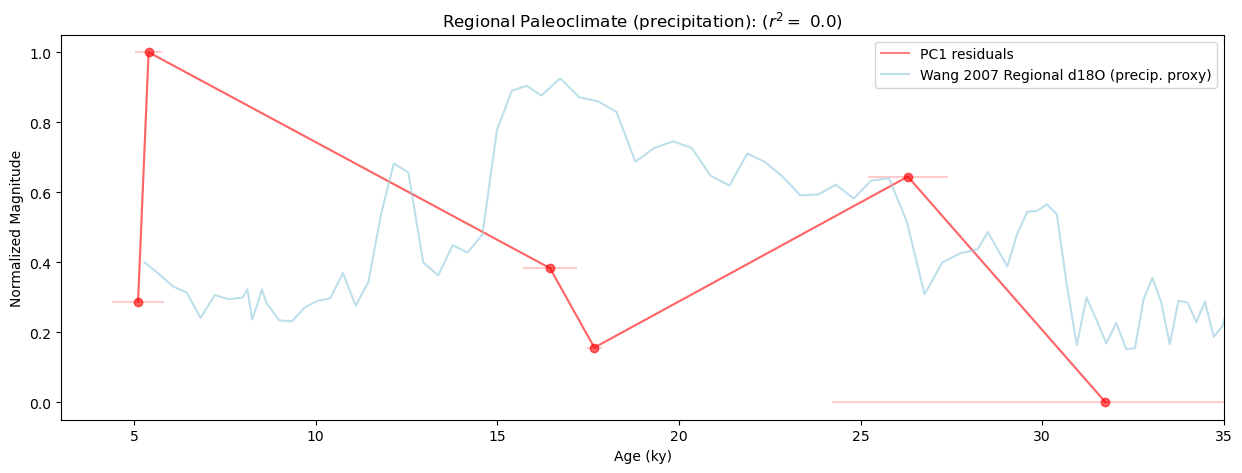

In [188]:
# plot paleoclimate data against PC1
# add moving average, a window of 1 is none

window = 1
precip_proxy_avg = movingaverage(precip_proxy['dO18'], window) 
yrs_per_window = (precip_proxy['dO18'].max() - precip_proxy['dO18'].min())/len(precip_proxy['dO18'])
yrs_per_window = round(yrs_per_window * window, 1)
precip_proxy_pts = np.interp(age_fans_precip, precip_proxy['age'], precip_proxy_avg) # extract proxy points for every age value 

fans_precip_avg = movingaverage(fans_precip, 1) 
fans_precip_pts = np.interp(age_proxy, age_fans_precip, fans_precip)

# Plot
plt.figure(figsize = (15,5))
plt.scatter(age_fans_precip, fans_precip, color = 'red', alpha = 0.5) # residual data 
plt.plot(age_fans_precip, fans_precip_avg, color = 'red', alpha = 0.5, label = 'PC1 residuals')
plt.errorbar(age_fans_precip, fans_precip_avg, xerr=age_sd[1:len(age_fans_precip)+1], c ='red', alpha = 0.2, fmt='-o')
plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
#plt.plot(age_proxy, precip_proxy_avg, color = 'blue', alpha = .4 ,label = 'Wang 2007 Regional d18O (precip. proxy)'.format(yrs_per_window)) 
plt.title('Paleoclimate (dO18 Global temp. proxy', size = 12)
plt.xlabel('Age (ky)', size = 10)
plt.ylabel('Normalized Magnitude', size = 10)
plt.legend()
plt.xlim(3,35)

# correlation coefficient (r --> r^2)
x_values = fans_precip
y_values = precip_proxy_pts # correlation to approximetly 35ka

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
rho, p = spearmanr(x_values, y_values)


plt.title('Regional Paleoclimate (precipitation): ($r^2 = $ {})'.format(round(r_squared,2)))

In [ ]:
plt.scatter(x_values,y_values, c = age_fans_precip)

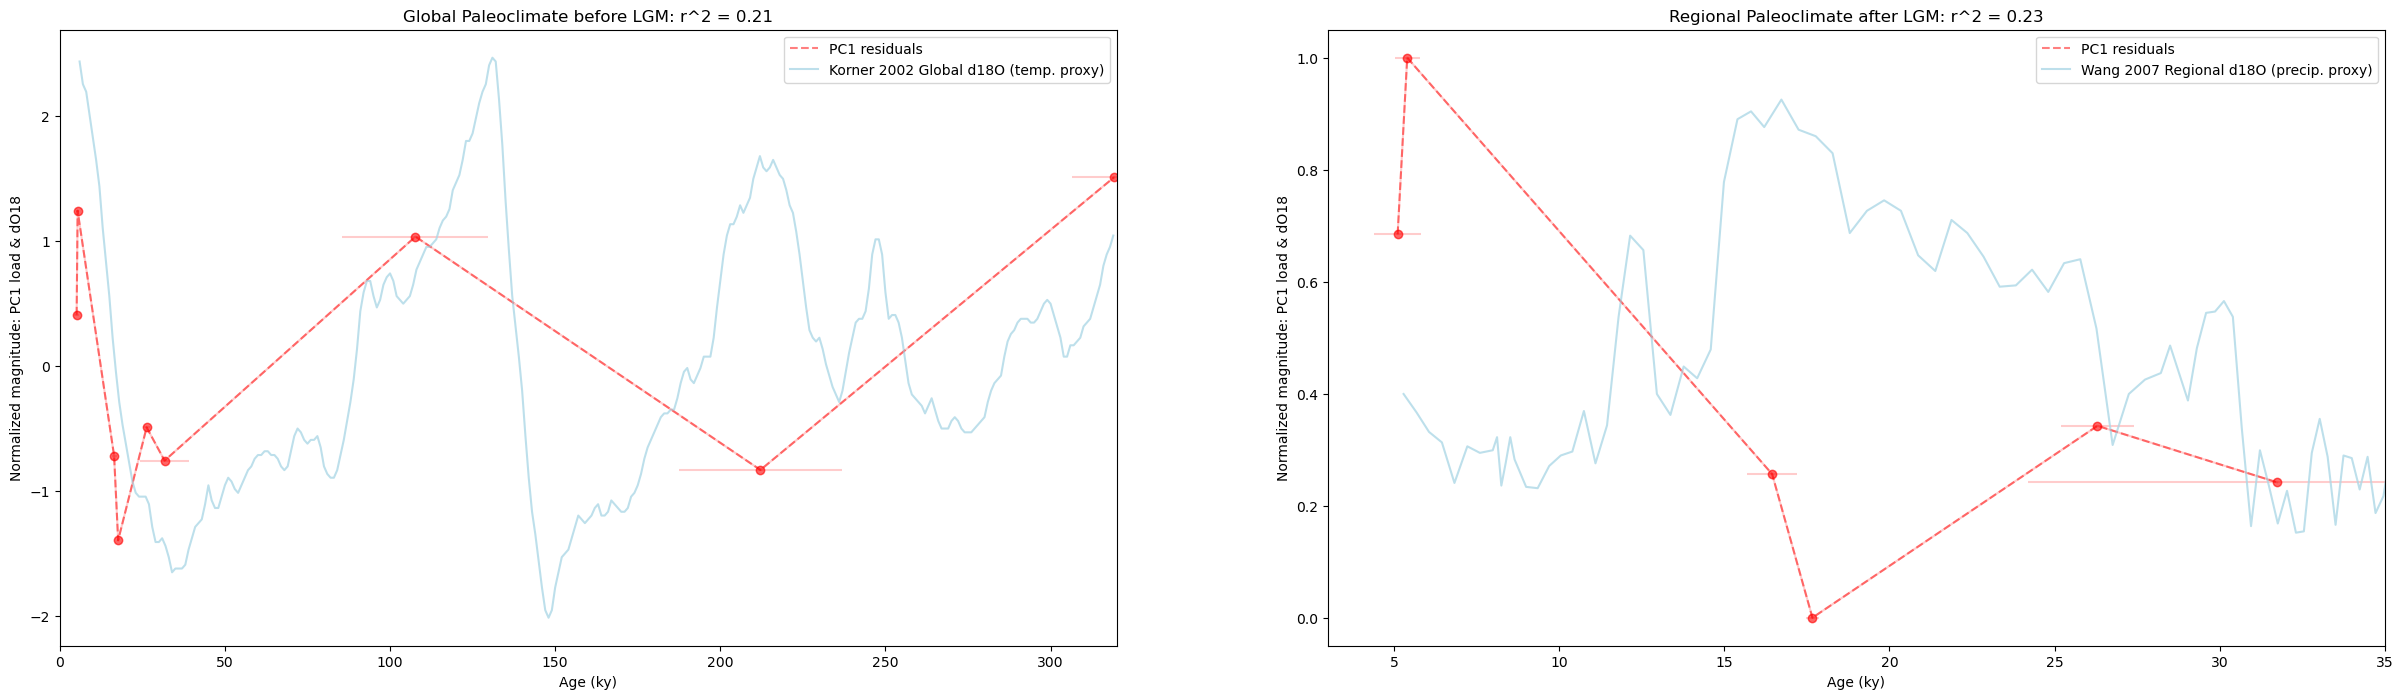

In [142]:
## PLOT ##
saveIt = 1
# global proxy
#fans_avg = movingaverage(fans, 1)
#fan_pts = np.interp(age_proxy, age_fans, fans)
window = 70
ice_proxy_avg = movingaverage(ice_proxy['dO18'], window)
yrs_per_window = (ice_proxy['age'].max() - ice_proxy['age'].min())/len(ice_proxy['age'])
yrs_per_window = round(yrs_per_window * window, 1)



plt.figure(figsize = (30,8))
plt.subplot(1,2,1)
plt.scatter(age_fans, fans, color = 'red', alpha = 0.5) # residual data 
plt.plot(age_fans, fans, color = 'red', alpha = 0.5, label = 'PC1 residuals', linestyle = '--')
plt.errorbar(age_fans, fans, xerr=age_sd[1:len(age_fans)+1], c ='red', alpha = 0.2, fmt='-o')
plt.plot(age_proxy, ice_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
#plt.plot(age_proxy, ice_proxy_avg, color = 'blue', alpha = .4 ,label = 'Korner 2002 Global d18O (temp. proxy): moving avergae = {} ky'.format(window)) 
plt.title('Paleoclimate (dO18 Global temp. proxy')
plt.xlabel('Age (ky)')
plt.ylabel('Normalized magnitude: PC1 load & dO18')
plt.legend()
plt.xlim(0, 320)


ice_proxy_pts = np.interp(age_fans, ice_proxy['age'], ice_proxy_avg) # interpret y values at given x (same shape for r^2)
fans_pts = np.interp(age_proxy, age_fans, fans) # extract points for every proxy value
#x_values = fans_pts[30:]
#y_values = ice_proxy_avg[30:]
x_values = fans
y_values = ice_proxy_pts
correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2 # interpret y values at given x (same shape for r^2)

plt.title('Global Paleoclimate before LGM: r^2 = {}'.format(round(r_squared,2)))

#plot regonal
plt.subplot(1,2,2)
plt.scatter(age_fans_precip, fans_precip, color = 'red', alpha = 0.5) # residual data 
plt.plot(age_fans_precip, fans_precip_avg, color = 'red', alpha = 0.5, linestyle = '--', label = 'PC1 residuals')
plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
plt.errorbar(age_fans_precip, fans_precip_avg, xerr=age_sd[1:len(age_fans_precip)+1], c ='red', alpha = 0.2, fmt='-o')
plt.title('Paleoclimate (dO18 Global temp. proxy')
plt.xlabel('Age (ky)')
plt.ylabel('Normalized magnitude: PC1 load & dO18')
plt.legend()
plt.xlim(3,35)

# correlation coefficient (r --> r^2)
x_values = fans_precip[:13]
y_values = precip_proxy_pts[:13] # correlation to approximetly 35ka

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

plt.title('Regional Paleoclimate after LGM: r^2 = {}'.format(round(r_squared,2)))

if saveIt:
    plt.savefig(sensor + '_proxies', bbox_inches = 'tight', dpi = 200)
    plt.show()

In [ ]:
pc = 0

# reconstruct data usin x PC
# y(t) - mean(y(t)) = sum(PC_j(t)*e_j)
# y(t) = sum(PC_j(t)*e_j) + mean(y(t))
# y(t) - mean(y(t)) / sum(e_j) = sum(PC_j(t)) <-- to project new data into PC space?
mean_y = np.mean(data,axis=0)
#test = np.array([PCs[jj,0]*eigvecs[0] + mean_y[jj] for jj in range(24)])
y_rec = np.array([PCs[jj,pc]*eigvecs[pc] + mean_y for jj in range(len(age))]) # + mean_y, or mean[jj] , or none
y_rec = pd.DataFrame(y_rec.T)

In [ ]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
y_rec = (y_rec -  y_rec.loc[0]) # choose band as zero point
max_all = y_rec.max().max()
min_all = y_rec.min().min()
y_rec = (y_rec - min_all)/(max_all - min_all) 
y_rec = y_rec

In [ ]:
# normalize each observation to have the same mean & std
y_rec = (y_rec - y_rec.mean())/y_rec.std()
y_rec = y_rec

In [ ]:
norm = plt.Normalize(vmin=min(age), vmax=max(age))

target_x = nm_names
target_y = y_rec.T
target_names = age

N = len(target_y) # number of objects to plot i.e. color cycle count

fig, ax = plt.subplots(figsize = (16,7))
#for i in range(N):
    #ax.plot(target_x, target_y.iloc[i], label = target_names[i]) # for i in range of objects, plot x,y
for i in range(N): 
    ax.plot(target_x, target_y.iloc[i],label = target_names[i], color=plt.cm.magma(norm(age[i])))
#axes
#plt.xticks(fontsize = 10, rotation=70, size = 8)
plt.xticks(np.arange(400, 2600, 50), fontsize = 10, rotation=70, size = 8)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xlabel('Wavelength (nm)', fontsize = 14)
plt.yticks(fontsize = 12)
plt.ylabel('Normalized Relative Reflectance', fontsize = 13)
plt.title("Reconstructed Spectral Profile", size = 14)
plt.title
plt.xlim()
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.magma), label = 'Age (ka)')

# legend location (if using discrete line key)
#box = ax.get_position()
#ax.set_position([box.x0, box.y0 + box.height * 0.1,
                # box.width, box.height * .9])

#ax.legend(loc='lower left', bbox_to_anchor=(1, 0),
          #fancybox=True, shadow=True, ncol=1, title = 'Age (ky)') # Put a legend below current axis
plt.rcdefaults() # reset global plt parameters, IMPORTANT!
plt.show()


In [ ]:
#nm_dict[193]
nm_dict[157]

In [ ]:
PC_scaled = np.array(PCs[:,1])
PC_scaled = (PC_scaled - np.min(PC_scaled)) / (np.max(PC_scaled) - np.min(PC_scaled))

#y_rec_ratio = y_rec.iloc[98]/ y_rec.iloc[194]
y_rec_ratio = (data[193]/data[157])
y_rec_ratio = np.array(y_rec_ratio).reshape(1,-1)
y_rec_ratio = (y_rec_ratio - np.min(y_rec_ratio)) / (np.max(y_rec_ratio) - np.min(y_rec_ratio))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(age, y_rec_ratio*-1, label = 'raw data ratio (scaled)')
plt.scatter(age, PC_scaled*-1, color = 'red', label = 'PCx scaled')
plt.legend()
plt.xlim()
plt.title('Can PCx be simplified? -- ex. D2200/D1800 Zhao et al')

plt.subplot(1,2,2)
test = y_rec_ratio - PC_scaled
plt.plot(age, test.T)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.title('index residuals to PCx')

In [ ]:
# Reconstruct from 1st PC
log(0)
pca = PCA(n_components=1)
PCs = pca.fit_transform(data)
P_rec = pca.inverse_transform(PCs)

# or do it manually 
# ADDITION RECONSTRUCT FROM PCs
#reconstruct data from PCs and eigenvectors
#y(t) - mean(y(t)) = sum(PC_j(t)*e_j)

#find mean for each y
#mean_y = np.mean(y,axis=1)

### reconstruct!
#y_rec = np.array([PCs[jj,0]*eigvecs[0] + PCs[jj,1]*eigvecs[1] + mean_y[jj] for jj in range(200)])

# Reconstruct from 1st PC
P_rect = P_rec.T

plt.figure(figsize = (15,8))
plt.plot(nm_names,P_rect[:,21], color = 'red')
plt.plot(nm_names, data.iloc[21])
plt.plot(nm_names,test[:,21], color = 'orange')

### MLR

In [ ]:
#import all required libraries etc

from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import itertools

#run notebook with functions we'll need
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    X = pd.DataFrame(X)
    y = pd.DataFrame(y)
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
#         print(excluded)
        new_pval = pd.Series(index=excluded, dtype = 'float64')
        for new_column in excluded:
#             print(included, new_column)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = excluded[new_pval.argmin()]
#             print(best_feature, included)
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(X.columns[worst_feature], worst_pval))
        if not changed:
            break
    return included

In [ ]:
X_train = data.copy()
X_train = X_train.reset_index(drop = True)
y_train = age

In [ ]:
# normalize each observation to have the same mean & std
X_train = (X_train - X_train.mean())/X_train.std()
X_train = X_train.T

In [ ]:
# normalize to a particular band (i.e. to Band 1 as zero), scale all observation 0 - 1 
X_train = (X_train -  X_train.loc[0]) # choose band as zero point
max_all = X_train.max().max()
min_all = X_train.min().min()
X_train = (X_train - min_all)/(max_all - min_all) 
X_train = X_train

In [ ]:

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(X_train,y_train)
ypred_MLR = lm_MLR.predict(X_train) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(X_train,y_train) #R-squared value from MLR model


print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
print('a2 = ' + str(coef_MLR[1]))
print('a3 = ' + str(coef_MLR[2]))
print('a4 = ' + str(coef_MLR[3]))
#print('a5 = ' + str(coef_MLR[4]))
#print('a6 = ' + str(coef_MLR[5]))
#print('etc...')
R2_MLR

In [ ]:
plt.plot(nm_names,coef_MLR)

In [ ]:
age_mod = lm_MLR.predict(X_train)
#age_mod_test = lm_MLR.predict(X_test)

plt.scatter(y_train, age_mod, c = 'blue')
#plt.scatter(y_test, age_mod_test, c = 'red')
plt.title('MLR all nm')

#print(age_mod_test)
#print(y_test)

In [ ]:
test = y_train-age_mod

plt.plot(age,test, c = 'blue')

In [ ]:
#now, use stepwise regression to find which predictors to use
import warnings
warnings.filterwarnings('ignore')
result = stepwise_selection(X_train, y_train,threshold_in=0.1,threshold_out=0.005)

print('resulting features:')
print(result)

In [ ]:
nm_dict[152]

In [ ]:
#do MLR using predictors chosen from stepwise regression
lm_step = linear_model.LinearRegression()
model_step = lm_step.fit(X_train[result],y_train)
ypred_step = lm_step.predict(X_train[result]) #y predicted by MLR
intercept_step = lm_step.intercept_ #intercept predicted by MLR
coef_step = lm_step.coef_ #regression coefficients in MLR model
R2_step = lm_step.score(X_train[result],y_train) #R-squared value from MLR model

print('stepwise MLR results:')
print('a0 = ' + str(intercept_step))
print('a1 = ' + str(coef_step[0]))
#print('a2 = ' + str(coef_step[1]))
#print('a3 = ' + str(coef_step[2]))

#visualize model (ADD y pred to legend!)

plt.figure(figsize=[40,5])

plt.subplot(1,2,1)
#plt.plot(X_train, '--', linewidth = 0.7)
plt.plot(y_train, color = 'black')
plt.plot(ypred_step, color = 'red')
#plt.legend(X + y)
plt.ylabel('Value')
plt.xlabel('Time')
plt.title('MLR data')

In [ ]:
plt.scatter(age_mod,ypred_step, color = 'red')
plt.title('MLR_step: R^2 = ' + str(R2_step)[:5], fontsize = 12)
#which predictor is most important?
print('Most important variable index for MLR: ', np.argmax(np.abs(coef_MLR)))
print('Most important variable index for stepwise: ', np.argmax(np.abs(coef_step)))
print()
print('Most important variable for MLR: ', X.columns[np.argmax(np.abs(coef_MLR))])
print('Most important variable for stepwise: ', result[np.argmax(np.abs(coef_step))])

In [ ]:
log(0) # save old data, to check against new projections
old_eigvecs = eigvecs
old_pcs = PCs

In [ ]:
mean_y = np.mean(data,axis=0)
np.shape(eigvecs[0])

In [ ]:
# apply trained PCA to new data (sample with origonal data subset)
data2 = data.copy()
data2 = data2[18:]
data2 = data2

age2 = age[18:]
n_modes = np.min(np.shape(data2)) 
new_pcs = pca.transform(data2)
new_eigvecs = pca.components_

In [ ]:
plt.scatter(age, old_pcs[:,1], c = 'blue')
plt.scatter(age2, new_pcs[:,1], c = 'red', alpha = 0.5)

In [ ]:
n = 10

plt.figure(figsize=(12,4*n))
for kk in range(n):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names, new_eigvecs[kk,:]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    plt.scatter(age,PCs[:,kk], color = 'blue')
    plt.scatter(age2,new_pcs[:,kk], color = 'red', marker = '^')
    #plt.colorbar(label = 'Age (ky)')
    plt.title('PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    
plt.show()


### rotated PCA

In [ ]:
def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T,np.array(Lambda)**3 - (gamma/p) * np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return R,np.dot(Phi, R)

R,PCr = varimax(PCs[:,:3])

e1r = R@np.array([1,0,0])
e2r = R@np.array([0,1,0])
e3r = R@np.array([0,0,1])

#rotate the first three eigenvectors
evects_rot = R@eigvecs[:3,:]

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(PCs[:,0],PCs[:,1],alpha=0.9, c = age)
plt.xlabel('PC1', fontsize = 8)
plt.ylabel('PC2', fontsize = 8)
plt.title('Data in PC Space', fontsize = 8)

In [ ]:
#plot rotated PC1 vs PC2 
plt.figure(figsize=(4,4))
plt.scatter(PCr[:,0],PCr[:,1],alpha=0.9, c= age)
plt.xlabel('PC1', fontsize = 8)
plt.ylabel('PC2', fontsize = 8)
plt.title('Data in PC Space', fontsize = 8)


In [ ]:
plt.figure(figsize=(12,4*n))

for kk in range(3):
    
    ax = plt.subplot(n,2,kk*2+1)
    plt.plot(nm_names, evects_rot[kk,:]) # extrat age as an array and do plt.plot(PCs[:,kk], age)
    plt.title('Rotated Eigenvector of Mode #' + str(kk+1), fontsize = 14)
    plt.xlabel('Wavelength (nm)', fontsize = 12)
    plt.xticks(fontsize = 10, rotation=70, size = 8)
    plt.xticks(np.arange(400, 2600, 100), fontsize = 10, rotation=70, size = 8)
    plt.yticks(fontsize = 14)
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    plt.grid()
    
    plt.subplot(n,2,(kk+1)*2)
    #plt.plot(age[1:],PCs[:,kk][1:], color = 'black')
    #plt.plot(age_precip_proxy, precip_proxy['dO18'], color = 'lightblue', alpha =.8 ,label = 'Wang 2007 Regional d18O (precip. proxy)')
    #plt.plot(age_proxy, ice_proxy['dO18'], color = 'red', alpha =.8 ,label = 'Korner 2002 Global d18O (temp. proxy)')
    plt.scatter(age,PCr[:,kk], color = 'blue')
    #plt.colorbar(label = 'Age (ky)')
    plt.title('Rotated PCs of Mode #' + str(kk+1) + ' ({}% var.exp)'.format(round(fracVar[kk]*100,1)), fontsize = 14)
    plt.xlabel('Age (ky)', fontsize = 12)
    plt.xticks(fontsize = 14, rotation=70, size = 10)
    plt.yticks(fontsize = 14)  
    plt.tight_layout()
    plt.xlim()
    plt.axhline(y=0.0, color='r', linestyle='--', alpha = 0.3)
    
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(nm_names, eigvecs[1,:], c = 'b', label = 'standard')
plt.plot(nm_names, evects_rot[1,:], color = 'red', label = 'rotated')
plt.legend()
plt.title('rotated pca: eigenvector')

plt.subplot(122)
plt.scatter(age,PCs[:,1], color = 'blue')
plt.scatter(age,PCr[:,1], color = 'red')
plt.title('rotated pcs: eigenvector')
plt.xlim()

In [ ]:
target_PC = data[5]/data[1]

plt.scatter(age, ratio)